In [1]:
pip install phik

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Загружаем нужные нам библиотеки
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import phik
from pickle import dump, load
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import GenericUnivariateSelect

pd.options.mode.chained_assignment = None

In [2]:
# Загружаем файл на котором будем обучать модели
df = pd.read_csv('D://Cardio/train.csv')

In [3]:
# проверяем, что файл нормально загрузился
df.head(6)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0


In [4]:
# посмортрим общюю информацию и есть ли пропски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
# посмотрим на минумумы и максимумы в столбцах
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Загружаем тестовый файл
test = pd.read_csv('D://Cardio/test.csv')

In [7]:
# проверим, что все нормально загрузилось
test.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


In [8]:
# посмотрим общюю информацию
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


In [9]:
# проверим на дубликаты
df.duplicated(['id']).value_counts()

False    70000
dtype: int64

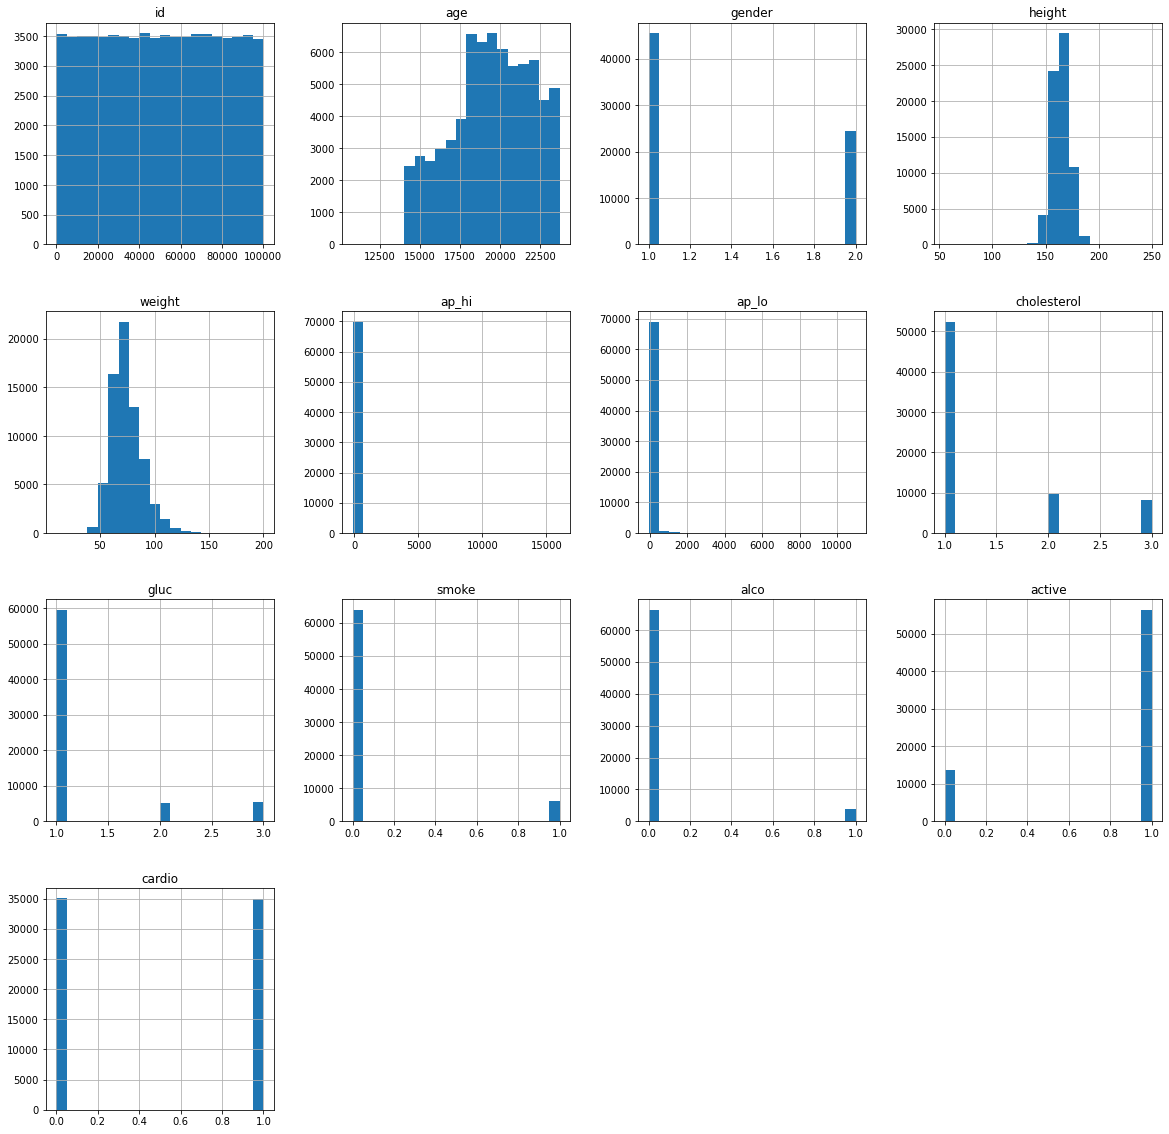

In [10]:
# построим гистограммы и посмотрим присутствуют ли выбросы
df.hist(figsize=(20, 20), bins=20)   
plt.show()

In [11]:
# напишем функцию по переводу дней в годы
def age_cat (age):
    age_year = age // 365
    return age_year

In [12]:
# применим функцию
df['age'] = df['age'].apply(age_cat)
test['age'] = test['age'].apply(age_cat)

In [13]:
# посмотрим, что у нас получи
df['age'].value_counts()

55    3927
53    3868
57    3686
56    3607
54    3605
59    3576
49    3417
58    3409
51    3368
52    3279
50    3216
60    3200
63    2736
61    2728
62    2199
47    2197
64    2187
45    2087
43    2031
41    1903
48    1811
39    1780
46    1625
40    1622
44    1514
42    1418
29       3
30       1
Name: age, dtype: int64

In [14]:
# Удалим выбросы из столбца height
print(f'До удаления выбросов в столбце weight:{df.shape[0]}')

df = df.query('(height >= 120) & (height <= 210)')

print(f'После удаления выбросов в столбце weight:{df.shape[0]}')

До удаления выбросов в столбце weight:70000
После удаления выбросов в столбце weight:69947


In [15]:
# Удалим выбросы из столбца weight
print(f'До удаления выбросов в столбце weight:{df.shape[0]}')

df = df.query('(weight >= 40) & (weight <= 170)')

print(f'После удаления выбросов в столбце weight:{df.shape[0]}')

До удаления выбросов в столбце weight:69947
После удаления выбросов в столбце weight:69881


In [16]:
# округлим данные в столбцах
df['weight'] = round(df['weight'])
test['weight'] = round(test['weight'])

In [17]:
# Посмотрим на выбросы в столбце ap_hi
df[df['ap_hi'] < 70].value_counts('ap_hi')

ap_hi
 12     74
 14     29
 11     28
 13     15
 15     12
 10      7
 20      4
 16      3
 17      3
-120     2
-100     2
 1       2
 24      1
-150     1
-140     1
 7       1
-115     1
 60      1
dtype: int64

In [18]:
# Посмотрим на выбросы в столбце ap_hi
df[df['ap_hi'] > 240].value_counts(df['ap_hi'])

ap_hi
906      6
14020    4
1400     3
907      3
13010    2
1420     2
1300     2
309      1
11500    1
11020    1
2000     1
1620     1
1500     1
1409     1
1205     1
401      1
1202     1
1130     1
1110     1
960      1
909      1
902      1
806      1
701      1
16020    1
dtype: int64

In [19]:
# напишем функцию для удаления и преобразования выбросов
def ap_hi(pres):
      
    if pres['ap_hi'] < 0:
        ap_hi = abs(pres['ap_hi'])
        pres['ap_hi'] = ap_hi
        
    elif (pres['ap_hi'] > 0) & (pres['ap_hi'] < 10):
        ap_hi = pres['ap_hi'] * 100
        pres['ap_hi'] = ap_hi
        
    elif (pres['ap_hi'] >= 10) & (pres['ap_hi'] <= 25):
        ap_hi = pres['ap_hi'] * 10
        pres['ap_hi'] = ap_hi
        
    elif (pres['ap_hi'] > 270) & (pres['ap_hi'] <= 2000):
        ap_hi = pres['ap_hi'] // 10
        pres['ap_hi'] = ap_hi
        
    elif (pres['ap_hi'] > 10000) & (pres['ap_hi'] <= 16500):
        ap_hi = pres['ap_hi'] // 100
        pres['ap_hi'] = ap_hi
        
    return pres

df = df.apply(ap_hi, axis = 1)
test = test.apply(ap_hi, axis = 1)

In [20]:
# проверим что получилось
print(df[df['ap_hi'] < 70].value_counts('ap_hi'))
print(df[df['ap_hi'] > 240].value_counts(df['ap_hi']))

ap_hi
30.0    1
40.0    1
60.0    1
dtype: int64
ap_hi
700.0    1
dtype: int64


In [21]:
# удалим все остальные выбросы
print(f'До удаления выбросов в столбце ap_hi:{df.shape[0]}')

df = df.query('(ap_hi >= 50)  & (ap_hi <= 270)')

print(f'После удаления выбросов в столбце ap_hi:{df.shape[0]}')

До удаления выбросов в столбце ap_hi:69881
После удаления выбросов в столбце ap_hi:69878


In [22]:
# посмотрим на выбросы в столбце ap_lo
df[df['ap_lo'] > 1000].value_counts(df['ap_lo'])

ap_lo
1100.0     154
1200.0      21
1110.0      11
1001.0       8
1120.0       5
1008.0       4
10000.0      3
8099.0       3
8000.0       2
1003.0       2
5700.0       2
9011.0       2
1088.0       2
1900.0       2
1400.0       2
1011.0       2
1033.0       2
1177.0       2
8044.0       1
8077.0       1
9800.0       1
8079.0       1
8200.0       1
7100.0       1
8500.0       1
9100.0       1
8100.0       1
1211.0       1
7099.0       1
6800.0       1
2088.0       1
1002.0       1
1140.0       1
1139.0       1
1125.0       1
1111.0       1
1101.0       1
1077.0       1
1044.0       1
1022.0       1
1007.0       1
11000.0      1
dtype: int64

In [23]:
# посмотрим на выбросы в столбце ap_lo
df[df['ap_lo'] < 40].value_counts(df['ap_lo'])

ap_lo
 0.0     20
 20.0    15
 10.0     7
 30.0     6
 6.0      2
 7.0      2
-70.0     1
 1.0      1
 8.0      1
 9.0      1
 15.0     1
dtype: int64

In [24]:
# напишем функцию для удаления и преобразования выбросов
def ap_lo(pres):
      
    if (pres['ap_lo'] > 0) & (pres['ap_lo'] <= 20):
        ap_lo = pres['ap_lo'] * 10
        pres['ap_lo'] = ap_lo
        
    elif (pres['ap_lo'] > 1000) & (pres['ap_lo'] <= 2200):
        ap_lo = pres['ap_lo'] // 10
        pres['ap_lo'] = ap_lo
        
    elif (pres['ap_lo'] > 5000) & (pres['ap_lo'] < 11500):
        ap_lo = pres['ap_lo'] // 100
        pres['ap_lo'] = ap_lo
        
    return pres

df = df.apply(ap_lo, axis = 1)
test = test.apply(ap_lo, axis = 1)

In [25]:
print(df[df['ap_lo'] > 1000].value_counts(df['ap_lo']))
print(df[df['ap_lo'] < 40].value_counts(df['ap_lo']))

Series([], dtype: int64)
ap_lo
 0.0     20
 30.0     6
-70.0     1
 10.0     1
dtype: int64


In [26]:
# удалим все остальные выбросы
print(f'До удаления выбросов в столбце ap_lo:{df.shape[0]}')

df = df.query('(ap_lo >= 40)  & (ap_lo <= 220)') 

print(f'После удаления выбросов в столбце ap_lo:{df.shape[0]}')

До удаления выбросов в столбце ap_lo:69878
После удаления выбросов в столбце ap_lo:69155


In [27]:
# проверим что все получилось
df.query('ap_hi <= ap_lo')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,681.0,52.0,1.0,156.0,65.0,120.0,150.0,2.0,1.0,0.0,0.0,1.0,0.0
636,913.0,56.0,2.0,169.0,68.0,70.0,110.0,1.0,1.0,0.0,0.0,1.0,0.0
2384,3356.0,64.0,1.0,154.0,102.0,90.0,150.0,1.0,1.0,0.0,0.0,0.0,1.0
2990,4214.0,60.0,2.0,182.0,90.0,80.0,140.0,3.0,3.0,0.0,0.0,1.0,1.0
3447,4880.0,54.0,2.0,180.0,80.0,80.0,125.0,3.0,3.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66657,95164.0,53.0,2.0,160.0,81.0,80.0,120.0,3.0,3.0,1.0,1.0,1.0,1.0
67421,96271.0,64.0,1.0,153.0,74.0,80.0,130.0,1.0,1.0,0.0,0.0,1.0,1.0
67470,96339.0,58.0,2.0,172.0,57.0,80.0,120.0,1.0,1.0,1.0,0.0,1.0,1.0
68067,97210.0,50.0,1.0,152.0,65.0,80.0,120.0,1.0,1.0,0.0,0.0,1.0,0.0


In [28]:
# напишем функцию для замены местами нужных нам значений в ap_hi и ap_lo
def swap_ap_hi (lo, hi):
    if hi > lo:
        return hi
    else:
        return lo
    
def swap_ap_lo (lo, hi):
    if lo < hi:
        return lo
    else:
        return hi

In [29]:
# применим функцию
df['ap_high'] = df.apply(lambda x: swap_ap_hi(x['ap_lo'],x['ap_hi']), axis = 1)
df['ap_low'] = df.apply(lambda x: swap_ap_lo(x['ap_lo'],x['ap_hi']), axis = 1)

test['ap_high'] = test.apply(lambda x: swap_ap_hi(x['ap_lo'],x['ap_hi']), axis = 1)
test['ap_low'] = test.apply(lambda x: swap_ap_lo(x['ap_lo'],x['ap_hi']), axis = 1)

df = df.drop(['ap_hi', 'ap_lo'], axis = 1)
test = test.drop(['ap_hi','ap_lo'], axis = 1)

In [30]:
# посмотрим что получилось
df.query('ap_high <= ap_low')

,id,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio,ap_high,ap_low
12785,18238.0,43.0,2.0,178.0,105.0,1.0,1.0,0.0,0.0,0.0,1.0,100.0,100.0
32190,45975.0,63.0,1.0,162.0,120.0,1.0,1.0,0.0,0.0,1.0,0.0,100.0,100.0


interval columns not set, guessing: ['id', 'age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'ap_high', 'ap_low']


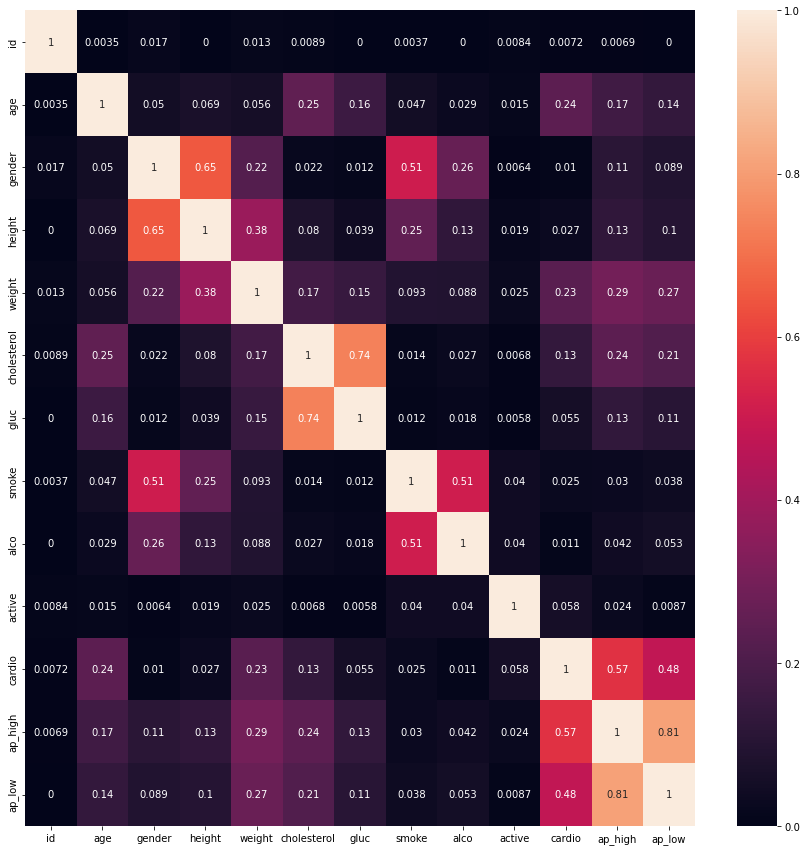

In [32]:
# посмотрим корреляцию между признаками и целевым признаком с помощью phik
plt.figure(figsize=(15, 15))    
sb.heatmap(df.phik_matrix(), annot=True)
plt.show()

In [33]:
# разделим файл на признаки и целевой признак
X_train = df.drop(['id','cardio', 'gender', 'height', 'alco'], axis = 1)
y_train = df['cardio']

In [34]:
# посмотрим, что получилось
X_train.head(5)

,age,weight,cholesterol,gluc,smoke,active,ap_high,ap_low
0,50.0,62.0,1.0,1.0,0.0,1.0,110.0,80.0
1,55.0,85.0,3.0,1.0,0.0,1.0,140.0,90.0
2,51.0,64.0,3.0,1.0,0.0,0.0,130.0,70.0
3,48.0,82.0,1.0,1.0,0.0,1.0,150.0,100.0
4,47.0,56.0,1.0,1.0,0.0,0.0,100.0,60.0


In [35]:
# применим метод горячего кодирования
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)
encoded = enc.transform(X_train).toarray()

In [36]:
# создадим переменную в которой будет датафрейм закодированых данных
X_train = pd.DataFrame(encoded, columns = enc.get_feature_names_out())

In [37]:
# посмотрим, что получилось
X_train.head()

,age_29.0,age_30.0,age_39.0,age_40.0,age_41.0,age_42.0,age_43.0,age_44.0,age_45.0,age_46.0,...,ap_low_126.0,ap_low_128.0,ap_low_130.0,ap_low_140.0,ap_low_150.0,ap_low_160.0,ap_low_170.0,ap_low_180.0,ap_low_182.0,ap_low_200.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# удалим еще один признак с целью уменьшить высокую корреляцию с признаком cholesterol
X_train = X_train.drop(['gluc_3.0'], axis = 1)

In [40]:
#Посмотрим что получилось
X_train.head()

,age_29.0,age_30.0,age_39.0,age_40.0,age_41.0,age_42.0,age_43.0,age_44.0,age_45.0,age_46.0,...,ap_low_126.0,ap_low_128.0,ap_low_130.0,ap_low_140.0,ap_low_150.0,ap_low_160.0,ap_low_170.0,ap_low_180.0,ap_low_182.0,ap_low_200.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# посмотрим на наиболее важные признаки в модели и те которые не вносят никакой ценности
decision_model = DecisionTreeClassifier().fit(X_train, y_train)

importances = decision_model.feature_importances_

X_list = list(X_train.columns)

feature_results = pd.DataFrame({'feature': X_list,'importance': importances})

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(40)

,feature,importance
0,ap_low_90.0,0.094497
1,ap_low_100.0,0.060165
2,cholesterol_3.0,0.049754
3,ap_high_140.0,0.036308
4,ap_high_130.0,0.021077
5,ap_high_150.0,0.020232
6,gluc_1.0,0.018062
7,ap_high_160.0,0.017267
8,ap_high_120.0,0.016792
9,ap_low_80.0,0.015911


In [42]:
feature_results['feature'].tail(40)

322     weight_143.0
323     ap_low_150.0
324     weight_133.0
325     ap_low_180.0
326     ap_low_182.0
327     ap_high_60.0
328     ap_high_96.0
329     ap_high_93.0
330    ap_high_178.0
331      ap_low_54.0
332      ap_low_53.0
333      ap_low_52.0
334      ap_low_45.0
335    ap_high_240.0
336    ap_high_230.0
337    ap_high_215.0
338    ap_high_208.0
339    ap_high_207.0
340    ap_high_202.0
341    ap_high_197.0
342    ap_high_188.0
343    ap_high_184.0
344    ap_high_181.0
345    ap_high_177.0
346      ap_low_57.0
347    ap_high_176.0
348    ap_high_174.0
349    ap_high_167.0
350    ap_high_156.0
351      ap_low_87.0
352    ap_high_149.0
353    ap_high_117.0
354    ap_high_116.0
355    ap_high_109.0
356    ap_high_107.0
357    ap_high_106.0
358    ap_high_102.0
359     ap_high_99.0
360     ap_high_97.0
361     ap_low_200.0
Name: feature, dtype: object

In [43]:
# обучим модель дерева решений и посмотрим метрику
decision_model = DecisionTreeClassifier(random_state = 12345, class_weight = 'balanced')

params = {'max_depth': range(32, 42, 2),
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': range(40, 52, 2)
          }

grid = GridSearchCV(decision_model, params, scoring = 'roc_auc', cv = 4, n_jobs = -1).fit(X_train, y_train)

print(grid.best_estimator_)
print(f'roc_auc модели: {grid.best_score_}')

best_model_decision = grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=36,
                       min_samples_leaf=48, random_state=12345)
roc_auc модели: 0.7898353299632471


In [44]:
# обучим модель случайного леса и посмотрим на метрику
random_model = RandomForestClassifier(random_state = 12345, class_weight = 'balanced')

params = {'max_depth': range(22, 32, 2),
          'max_features': ['sqrt', 'log2'],
          'min_samples_split': range(52, 62, 2),
          'criterion': ['gini', 'entropy']
          }

grid = GridSearchCV(random_model, params, scoring = 'roc_auc', cv = 3, n_jobs = -1).fit(X_train, y_train)

print(grid.best_estimator_)
print(f'roc_auc модели: {grid.best_score_}')

best_model_random = grid.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features='sqrt', min_samples_split=52,
                       random_state=12345)
roc_auc модели: 0.7951527107302736


In [66]:
# проверим лучшие модели через кросс валидацию и посмотирм на метрики
print('Сравнение моделей кросс-валидацией:')
print()
print('ROC-AUC модели DecisionTree:', cross_val_score(best_model_decision, X_train, y_train,\
                                                      cv=5, scoring='roc_auc').mean())
print()
print('ROC-AUC модели RandomForest:', cross_val_score(best_model_random, X_train, y_train,\
                                                   cv=5, scoring='roc_auc').mean())

Сравнение моделей кросс-валидацией:

ROC-AUC модели DecisionTree: 0.7901540311077871

ROC-AUC модели RandomForest: 0.7953431940427749


In [45]:
# удалим признаки как в тренировачной модели
X_test = test.drop(['id', 'gender', 'height', 'alco'], axis = 1)
X_test.head(5)

,age,weight,cholesterol,gluc,smoke,active,ap_high,ap_low
0,51.0,85.0,1.0,1.0,0.0,1.0,130.0,80.0
1,52.0,69.0,1.0,1.0,0.0,1.0,130.0,90.0
2,55.0,70.0,1.0,1.0,0.0,0.0,120.0,75.0
3,49.0,94.0,1.0,1.0,0.0,1.0,130.0,90.0
4,44.0,76.0,1.0,1.0,0.0,1.0,120.0,80.0


In [46]:
# трансформируем тестовый файл, методом горячего кодирования и посмотрим, что получилось
encoded = enc.transform(X_test).toarray()

X_test = pd.DataFrame(encoded, columns = enc.get_feature_names_out())

X_test.head(5)

,age_29.0,age_30.0,age_39.0,age_40.0,age_41.0,age_42.0,age_43.0,age_44.0,age_45.0,age_46.0,...,ap_low_126.0,ap_low_128.0,ap_low_130.0,ap_low_140.0,ap_low_150.0,ap_low_160.0,ap_low_170.0,ap_low_180.0,ap_low_182.0,ap_low_200.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# удалим признаки как в тренировачной модели
X_test = X_test.drop(['gluc_3.0'], axis = 1)

In [48]:
# обучим выбранную нами модель, проверим на тестовой выборке и посмотрим метрики
best = best_model_random

best = best.fit(X_train, y_train)

predict = best.predict(X_test)

probabilities_best = best.predict_proba(X_test)

probabilities_best = probabilities_best[:, 1]

In [49]:
# посмотрим на 
probabilities_best

array([0.50815337, 0.60359024, 0.36267681, ..., 0.44251775, 0.38424534,
       0.68948885])

In [ ]:
# далее идет сохранение полученных предсказаний и сохранение их в файл для отправки на Kaggle

In [50]:
test = pd.read_csv('D://Cardio/sample_submission.csv')

In [51]:
test['cardio'] = probabilities_best

In [52]:
test.to_csv('D://Cardio/sample_submission1.csv', index=False)

In [53]:
pipe = Pipeline([
    ('enc', OneHotEncoder()),
    ('Random', best_model_random)
])

In [54]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('enc', OneHotEncoder()),
                ('Random',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=30,
                                        max_features='sqrt',
                                        min_samples_split=52,
                                        random_state=12345))])

In [55]:
y_pred = pipe.predict_proba(X_test)[:,1]

y_pred

array([0.51416235, 0.5817783 , 0.36118471, ..., 0.49230186, 0.39730963,
       0.76701038])

In [56]:
with open('D://Cardio/model1.pcl', 'wb') as fid:
    dump(pipe, fid)